![picture](https://drive.google.com/uc?export=view&id=1K_GhwMAZaYPEqm-0ukMBxfmBew7N6GXA)<br>
<small>Rian Lopes</small><br>

Inscreva-se no canal <br>[Data Review](https://www.youtube.com/channel/UCYfY8KRS5nqoFBTuoLV0_jw) <br>
E siga nas redes sociais <br> [Instagram Data Review](https://www.instagram.com/data.review/)
<br>
<br>
<h1>Spark for Data Science and Machine Learning</h1>
<h2>EDA</h2>


In [ ]:
## Montar o Google Driver para utilização como disco
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


<h2>New York TLC Data</h2>
Os dados de registros de viagens do TLC (Taxi and Limousine Commission) de Nova York são conjuntos de informações detalhadas sobre viagens realizadas por táxis, carros de aplicativo (como Uber e Lyft) e outros serviços de transporte autorizados na cidade.

[New York City Taxi/Uber Data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page)

In [ ]:
!mkdir -p /content/spark/

In [ ]:
from pyspark.sql import SparkSession
from datetime import datetime
from dateutil.relativedelta import relativedelta
import os
import requests

def download_file(url, output_path):
    """Download a file from a URL to a local path."""
    if os.path.exists(output_path):
        print(f"File {output_path} already exists. Skipping download.")
        return
    print(f"Downloading {url} to {output_path}")
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(output_path, "wb") as f:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    f.write(chunk)
    else:
        print(f"Failed to download {url}. Status code: {response.status_code}")

# Inicializa a sessão Spark
spark = SparkSession.builder \
    .master("local") \
    .appName("loadingDataSpark1") \
    .getOrCreate()

# Defina uma data de referência, por exemplo, o mês mais recente disponível.
# Aqui, usamos 2024-01-01 como referência (janeiro de 2024)
ref_date = datetime(2024, 1, 1)

# Monta a lista de caminhos dos arquivos para os últimos 6 meses
file_paths = []
for i in range(12):
    month_date = ref_date - relativedelta(months=i)

    file_name = f"yellow_tripdata_{month_date.year}-{month_date.month:02d}.parquet"
    file_url = f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file_name}"
    output_path = f"/content/spark/{file_name}"

    # Call the download function
    download_file(file_url, output_path)

    # Add the output path to the list
    file_paths.append(output_path)

print("Arquivos a serem carregados:", file_paths)

# Carrega os arquivos usando a lista de caminhos
df = spark.read.format("parquet") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load(file_paths)



Arquivos a serem carregados: ['/content/spark/yellow_tripdata_2024-01.parquet', '/content/spark/yellow_tripdata_2023-12.parquet', '/content/spark/yellow_tripdata_2023-11.parquet', '/content/spark/yellow_tripdata_2023-10.parquet', '/content/spark/yellow_tripdata_2023-09.parquet', '/content/spark/yellow_tripdata_2023-08.parquet', '/content/spark/yellow_tripdata_2023-07.parquet', '/content/spark/yellow_tripdata_2023-06.parquet', '/content/spark/yellow_tripdata_2023-05.parquet', '/content/spark/yellow_tripdata_2023-04.parquet', '/content/spark/yellow_tripdata_2023-03.parquet', '/content/spark/yellow_tripdata_2023-02.parquet']


In [ ]:
df.count()

38208084

In [ ]:
df.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- Airport_fee: double (nullable = true)



<h3>Problema de Negócio</h3>
O Departamentode Trânsito de NY está estudando novas políticas públicas para aumentar a eficiência da mobilidade urbana na cidade.
Para isso, o Departamento requisitou que você respondesse algumas questões a respeito da base de dados pública de corridas de taxis:



1.   Qual é a média das distâncias percorridas por viagem?
2.   Qual é a média do valor pago por corrida?
3.   Qual é a média do valor pago por km?
4.   Qual é época do ano tem mais corridas?
5.   Quais dias da semana tem mais corridas?
6.   Quais os locais mais comuns de embarque e desembarque?
7.   Existe relação entre o local de embarque e o valor da corrida?



[Yellow Taxi Trip Record Dictionary
](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf)

In [ ]:
from pyspark.sql.functions import col, count, avg, min, max, stddev, year, month, dayofweek

In [ ]:
df.select("trip_distance", "fare_amount", "tip_amount", "total_amount").describe().show()

+-------+-----------------+-----------------+-----------------+------------------+
|summary|    trip_distance|      fare_amount|       tip_amount|      total_amount|
+-------+-----------------+-----------------+-----------------+------------------+
|  count|         38208084|         38208084|         38208084|          38208084|
|   mean|4.074448336901812|19.51044069965726|3.520189549154177|28.448812140056575|
| stddev|239.3783121302717|75.84454426229561|4.153015583536009| 77.25099396472079|
|    min|              0.0|          -1087.3|           -411.0|          -1094.05|
|    max|        345729.44|        386983.63|           4174.0|         386987.63|
+-------+-----------------+-----------------+-----------------+------------------+



In [ ]:
df_stats = df.select("trip_distance", "fare_amount", "tip_amount", "total_amount").describe().toPandas()
df_stats.set_index("summary", inplace=True)
df_stats = df_stats.astype(float).round(2)
df_stats

,trip_distance,fare_amount,tip_amount,total_amount
summary,,,,
count,38208084.00,38208084.00,38208084.00,38208084.00
mean,4.07,19.51,3.52,28.45
stddev,239.38,75.84,4.15,77.25
min,0.00,-1087.30,-411.00,-1094.05
max,345729.44,386983.63,4174.00,386987.63


In [ ]:
df = df.withColumn("trip_distance_km", col("trip_distance")*1.6)

In [ ]:
df.agg(avg('total_amount')).collect()[0][0]/df.agg(avg('trip_distance_km')).collect()[0][0]

4.363905519791876

In [ ]:
df.withColumn("month", month("tpep_pickup_datetime")).groupBy("month").count().orderBy("month").show()

+-----+-------+
|month|  count|
+-----+-------+
|    1|2964650|
|    2|2913996|
|    3|3403660|
|    4|3288248|
|    5|3513664|
|    6|3307259|
|    7|2907093|
|    8|2824201|
|    9|2846741|
|   10|3522269|
|   11|3339732|
|   12|3376571|
+-----+-------+



In [ ]:
df_pandas1 = df.withColumn("month", month("tpep_pickup_datetime")).groupBy("month").count().orderBy("month").toPandas()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt


<Axes: xlabel='month', ylabel='count'>

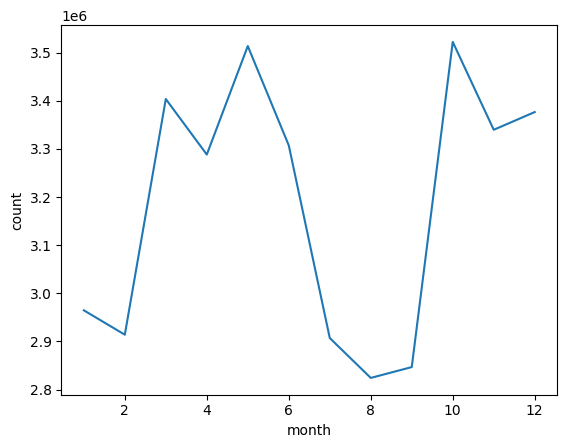

In [ ]:
sns.lineplot(data=df_pandas1, x='month', y='count')

In [ ]:
df.withColumn("day_of_week", dayofweek("tpep_pickup_datetime")).groupBy("day_of_week").count().orderBy("day_of_week").show()

+-----------+-------+
|day_of_week|  count|
+-----------+-------+
|          1|4748045|
|          2|4778609|
|          3|5510452|
|          4|5943456|
|          5|5988989|
|          6|5676518|
|          7|5562015|
+-----------+-------+



In [ ]:
df.filter(col("trip_distance")>10).withColumn("day_of_week", dayofweek("tpep_pickup_datetime")).groupBy("day_of_week").count().orderBy("day_of_week").show()

+-----------+------+
|day_of_week| count|
+-----------+------+
|          1|503046|
|          2|508837|
|          3|456695|
|          4|473050|
|          5|489055|
|          6|478232|
|          7|390203|
+-----------+------+



In [ ]:
df.show(10)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|  trip_distance_km|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+------------------+
|       1| 2023-10-01 00:16:44|  2023-10-01 00:16:49|              1|          0.0|         1|                 N|         168|    

In [ ]:
import pandas as pd
df_lookup = pd.read_csv("https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv")
df_lookup

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NaN,NaN


In [ ]:
df_topten_pu = df.groupBy("PULocationID").count().orderBy(col('count').desc()).toPandas().head(10)
df_topten_pu

,PULocationID,count
0,132,1977514
1,237,1786429
2,161,1774095
3,236,1594658
4,162,1355136
5,138,1305604
6,186,1300409
7,230,1278014
8,142,1259876
9,170,1126391


In [ ]:
df_topten_do = df.groupBy("DOLocationID").count().orderBy(col('count').desc()).toPandas().head(10)
df_topten_do

,DOLocationID,count
0,236,1672887
1,237,1603154
2,161,1480474
3,230,1179345
4,170,1126186
5,162,1085664
6,142,1069853
7,239,1062151
8,141,1001874
9,68,968309


In [ ]:
pd.merge(df_topten_pu, df_lookup, left_on="PULocationID", right_on="LocationID", how="left")[["PULocationID", "Borough", "Zone", "count"]]

,PULocationID,Borough,Zone,count
0,132,Queens,JFK Airport,1977514
1,237,Manhattan,Upper East Side South,1786429
2,161,Manhattan,Midtown Center,1774095
3,236,Manhattan,Upper East Side North,1594658
4,162,Manhattan,Midtown East,1355136
5,138,Queens,LaGuardia Airport,1305604
6,186,Manhattan,Penn Station/Madison Sq West,1300409
7,230,Manhattan,Times Sq/Theatre District,1278014
8,142,Manhattan,Lincoln Square East,1259876
9,170,Manhattan,Murray Hill,1126391


In [ ]:
pd.merge(df_topten_do, df_lookup, left_on="DOLocationID", right_on="LocationID", how="left")[["DOLocationID", "Borough", "Zone", "count"]]

,DOLocationID,Borough,Zone,count
0,236,Manhattan,Upper East Side North,1672887
1,237,Manhattan,Upper East Side South,1603154
2,161,Manhattan,Midtown Center,1480474
3,230,Manhattan,Times Sq/Theatre District,1179345
4,170,Manhattan,Murray Hill,1126186
5,162,Manhattan,Midtown East,1085664
6,142,Manhattan,Lincoln Square East,1069853
7,239,Manhattan,Upper West Side South,1062151
8,141,Manhattan,Lenox Hill West,1001874
9,68,Manhattan,East Chelsea,968309


In [ ]:
df.groupBy("PULocationID").agg(avg("total_amount")).show(20)

+------------+------------------+
|PULocationID| avg(total_amount)|
+------------+------------------+
|         148| 25.63326855349845|
|         243| 36.27270607826811|
|          31|  46.3472888888889|
|         137|22.241337596647856|
|          85|  33.6335669869983|
|         251| 73.59706666666668|
|          65|32.341113015795266|
|         255|30.594767914306857|
|          53|41.662503770739065|
|         133| 34.76307138179436|
|          78| 33.74367424242423|
|         108| 46.26627345844504|
|         155| 41.99097124253935|
|         211|24.755113310568312|
|          34| 30.30008373205741|
|         193| 9.927852151898758|
|         126| 33.99465851172273|
|         101| 40.94256821829856|
|         115| 57.12083333333333|
|          81| 39.26791803278688|
+------------+------------------+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import corr

df.select(corr("PULocationID", "total_amount")).collect()[0][0]

-0.03499688688825593